# Information retrieval en NLP 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Derivatie van $N$-grams

Wat willen we modelleren? 
- De kans op een bepaalde taal, gegeven een input tekst
- $p(l | c_{1:N})$
- $l$ een kansvariabele is die de taal representeert (e.g., $l=\text{NL}, l=\text{ENG}$)
- $c_{1:N}$ is een verkorting voor de reeks aan kansvariabelen $c_1, c_2, \dots, c_N$, die een sequentie aan **karakters** representeren (of **woorden**). 
- Bijv. voor de string `hallo` krijgen we $c_1=\text{`h'}, c_2=\text{`a'}, c_3=\text{`l'}, c_4=\text{`l'}, c_5=\text{`o'}$

Met de **regel van Bayes** kunnen we de voorwaarde in de kans omdraaien:
$$
    p(l | c_{1:N}) = \dfrac{p(c_{1:N} | l) p(l)}{p(c_{1:N})}
$$

Met de **product regel** kunnen we de term $p(c_{1:N} | l)$ ontleden: 
\begin{align*}
    p(c_{1:N} | l) &= p(c_1, c_2, \dots, c_N | l)\\ 
    &= p(c_1 | l) p(c_2 | l, c_1) p(c_3 | l, c_1, c_2) \dots p(c_N | l, c_1, c_2, \dots, c_{N-1})\\
    &= \prod_{i=1}^N p(c_i | l, c_{i-1}, c_{i-2}, \dots, c_{2}, c_{1})\\
    &= \prod_{i=1}^N p(c_i | l, c_{i-1:1})
\end{align*}

Voorbeeld (spatie = `_`): 
$$
    \overbrace{\underbrace{\boxed{\text{Hallo\_ik\_ben\_}}}_{\large c_{i-1:1}}}^{\text{Context window}} \underbrace{\boxed{\text{A}}}_{\large c_{i}}\text{lice}
$$

Dit is echter **intractable** voor lange sequenties, waardoor we aannames maken om het probleem te versimpelen
- In plaats van de gehele context $c_{i-1:1}$ mee te nemen, kunnen we enkel een paar stappen terug kijken, $c_{i-1:i-t}$
- Waarbij $t$ de order van de markov-chain is
- Als $t=0$, dan krijgen we $p(c_i | l)$. Kans op karakter is onafhankelijk van de context waar het karakter zich in bevind (uni-gram).
- Als $t=1$, dan krijgen we $p(c_i | l, c_{i-1})$. Kans op karakter is alleen afhankelijk van het karakter direct ervoor (bi-gram).
- Als $t=2$, dan krijgen we $p(c_i | l, c_{i-1}, c_{i-2})$. Ieder karakter is afhankelijk van het karakter ervoor en die daarvoor (tri-gram).

Voorbeeld tri-grams voor de input `Hallo`:
\begin{align*}
    \boxed{\text{<pad><pad>H}} \rightarrow p(c_1 &= \text{H} &| l, c_{0} &= \text{<pad>}, &c_{-1} &= \text{<pad>})  &&&&\\
    \boxed{\text{<pad>Ha}} \rightarrow p(c_2 &= \text{a} &| l, c_{1} &= \text{H}, &c_{0} &= \text{<pad>})       &&&& \\
    \boxed{\text{Hal}} \rightarrow p(c_3 &= \text{l} &| l, c_{2} &= \text{a}, &c_{1} &= \text{H})           &&&& \\
    \boxed{\text{all}} \rightarrow p(c_4 &= \text{l} &| l, c_{3} &= \text{l}, &c_{2} &= \text{a})           &&&&\\
    \boxed{\text{llo}} \rightarrow p(c_5 &= \text{o} &| l, c_{4} &= \text{l}, &c_{3} &= \text{l})           &&&&\\
\end{align*}

Implementatie:
- een voorwaardelijke kans kan je zien als een tabel waarbij je indexeert op de waarden van de voorwaardelijke kansvariabelen.
- hoe meer variabelen in de voorwaarde, des te meer dimensies deze tabel heeft (voor tri-grams krijg je 3 dimensies).
- pas *smoothing* toe om de kans op 0 te vermijden.
- **Training**: Voor iedere taal, bereken tri-grammen en sla frequentie op in tabel (array of dictionary)
- **Inference**: Gegeven een input tekst, bereken $l^* = \text{argmax}_l\;\; p(l | c_{1:N})$. m.a.w. het argument (taal $l$) waarbij de voorwaardelijke kans maximaal is.
\begin{align*}
    l^* &= \text{argmax}_l\;\; p(l | c_{1:N})\\[.5cm]
    &= \text{argmax}_l \dfrac{p(c_{1:N} | l) p(l)}{\underbrace{p(c_{1:N})}_{\text{norm term kan weg}}} = \text{argmax}_l \;\;p(c_{1:N} | l) p(l)\\[1cm]
    &= \text{argmax}_l \;\;p(l) \prod_{i=1}^N p(c_i | l, c_{i-1}, c_{i-2})
\end{align*}

## Information retrieval

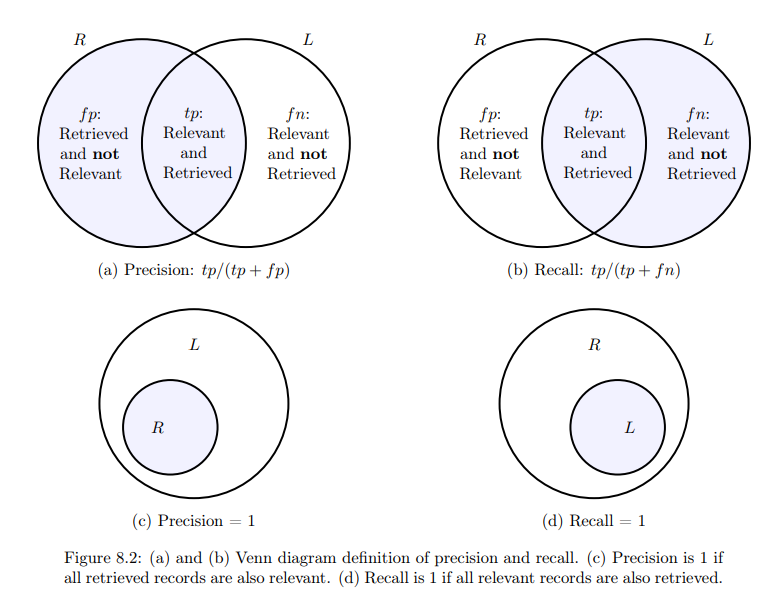

### Scoring function

**Best matching 25** (BM25) is een scoring functie om een document $d_j$ te rankschikken op basis van een set aan queries $Q = \{q_1, q_2, \dots, q_n\}$:
$$
    BM25(d_j, q_{1:n}) = \sum_{i=1}^n IDF(q_i) \dfrac{TF(q_i, d_j) (k+1)}{TF(q_i, d_j) + k \left(1-b + b \dfrac{|d_j|}{L}\right)}
$$

waarbij:
- $d_j \in D$ en $D$ een corpus van $N$ documenten is;
- $TF(q_i, d_j)$ is de *term frequency* van $q_i$ in $d_j$, oftewel het aantal keer dat de zoekterm $q_i$ voorkomt in document $d_j$;
- $DF(q_i)$ is de *document frequency* van $q_i$, oftewel het aantal documenten met de zoekterm $q_i$;
- $IDF(q_i)$ is de *inverse document frequency* van $q_i$: $IDF(q_i) = \log \dfrac{N-DF(q_i) + 0.5}{DF(q_i) + 0.5}$;
- $L = \sum_{i=1}^N |d_i|/N$ is de gemiddelde lengte van documenten in het corpus $D$;
- $k$ en $b$ zijn instelbare parameters (bijv. 2.0, of 0.75)

In [17]:
import math
import json

f = open('data/mini_RN_corpus.json', 'r', encoding="utf8")
corpus = json.load(f)
corpus

{'2 intelligent agents': 'In which we discuss the nature of agents, perfect or otherwise, the diversity of environments, and the resulting menagerie of agent types. Chapter 1 identified the concept of rational agents as central to our approach to artificial intelligence. In this chapter, we make this notion more concrete. We will see that the concept of rationality can be applied to a wide variety of agents operating in any imaginable environment. Our plan in this book is to use this concept to develop a small set of design principles for building successful agents—systems that can reasonably be called intelligent. We begin by examining agents, environments, and the coupling between them. The observation that some agents behave better than others leads naturally to the idea of a rational agent—one that behaves as well as possible. How well an agent can behave depends on the nature of the environment; some environments are more difficult than others. We give a crude categorization of en

In [32]:
def tf(q: str, d: str):
    freq = 0
    for word in d.split():
        if q == word: freq += 1
    return freq

def df(q: str, D: list[str]):
    freq = 0
    for d in D:
        if q in d.split(): freq += 1
    return freq

def idf(q: str, D: list[str]):
    d_freq = df(q, D)
    return math.log((len(D) - d_freq + 0.5) / (d_freq + 0.5))

def BM25(d: str, Q: list[str], D: list[str], k: float, b: float):
    result = 0
    L = sum(len(d_i) for d_i in D) / len(D)
    for q in Q:
        tf_qd = tf(q, d)
        result += idf(q, D) * (tf_qd * (k+1)) / (tf_qd + k * (1 - b + b * len(d) / L))
    
    return result

k, b = 2.0, 0.75
Q = ['learning', 'search', 'language']
{name: BM25(dj, Q, corpus, k, b) for name, dj in corpus.items()}

{'2 intelligent agents': 0.0,
 '3 solving problems by searching': 0.09095612528670763,
 '4 beyond classical search': 0.08716363834836133,
 '18 learning from examples': 0.1523341065907487,
 '22 natural language processing': 0.07591671727115341,
 '24 perception': 0.0}

## Attention, Transformers, en ChatGPT

[Attention Is All You Need](https://arxiv.org/abs/1706.03762) (2017)

Vanuit een information retrieval perspectief:
- we hebben een database $\mathcal{D}$ bestaande uit keys $\mathbf{K}$ en values $\mathbf{V}$
- op basis van een query $\mathbf{q}$ willen we informatie ophalen uit de database

In [33]:
query = "x"

database = {
    "x": "Hello, world!",
    "y": "Discussiecollege week 8",
    "z": "Minor AI"
}

database[query]

'Hello, world!'

Hoe kunnen we de query operatie op een numerieke manier uitvoeren (in plaats van met strings)?
- One-hot encoding van query en keys 
- Label-encoding van values

In [34]:
# one-hot encoding
query = np.array([1, 0, 0])
keys = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# label-encoding
max_token = len(max(database.values(), key=lambda x: len(x)))
values = np.array([
    [ord(c) for c in list(val) + ([' '] * (max_token - len(val)))] 
    for val in database.values()
])

query, keys, values

(array([1, 0, 0]),
 array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 array([[ 72, 101, 108, 108, 111,  44,  32, 119, 111, 114, 108, 100,  33,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32],
        [ 68, 105, 115,  99, 117, 115, 115, 105, 101,  99, 111, 108, 108,
         101, 103, 101,  32, 119, 101, 101, 107,  32,  56],
        [ 77, 105, 110, 111, 114,  32,  65,  73,  32,  32,  32,  32,  32,
          32,  32,  32,  32,  32,  32,  32,  32,  32,  32]]))

De numerieke query operatie is als volgt:

We nemen het dot product (gewogen som) tussen iedere key $\mathbf{k}_i \in \mathbf{K}$ en de query $\mathbf{q}$

$$
    \mathbf{k}_i \cdot \mathbf{q} = \sum_{j=1}^d k_{ij}q_j
$$

We kunnen dit ook opvatten als een matrix-vector product tussen alle keys $\textbf{K}$ en de query vector $\textbf{q}$ (denk terug aan week 5):

\begin{align*}
    \textbf{K} \cdot \textbf{q} &= \underbrace{\begin{bmatrix} 
        k_{11} & k_{12} & \dots & k_{1d} \\
        k_{21} & k_{22} & \dots & k_{2d} \\
        \vdots & \vdots & \ddots & \vdots \\
        k_{N1} & k_{N2} & \dots & k_{Nd} \\
    \end{bmatrix} \cdot \begin{bmatrix} q_1 \\ q_2 \\ \vdots \\ q_d \end{bmatrix}}_{\text{matrix-vector product}}\\
\end{align*}

Visualisatie: http://matrixmultiplication.xyz/

Meestal normaliseren we het resultaat $\textbf{K} \cdot \textbf{q}$ in iedere rij van de matrix zodanig dat de som van de rijen 1 is. In dit geval is dat niet nodig omdat we een handmatige encoding hebben uitgevoerd.

Dan op dezelfde wijze, een matrix-matrix product tussen $\textbf{K} \cdot \textbf{q}$ en $\textbf{V}$, waarmee de informatie wordt opgehaald aan de hand van $\textbf{q}$

In [38]:
out = (keys @ query) @ values
out_str = ''.join([chr(i) for i in out]).strip()
out, out_str

(array([ 72, 101, 108, 108, 111,  44,  32, 119, 111, 114, 108, 100,  33,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32]),
 'Hello, world!')

### Attention in Transformers:
- Het revolutionaire aan de **Transformer** is dat de *query*, *keys*, en *values* leerbare parameters zijn.
- Net zoals de gewichten in een standaard MLP model.
- Dit **attention mechanisme** waarbij een input naar zichzelf en de context kijkt heet **self-attention**.
- Hierdoor leert een transformer een **continue representatie** van een information retrieval systeem. 
- Verschil tussen **encoder-only**, **decoder-only**, en **encoder-decoder** Transformers.

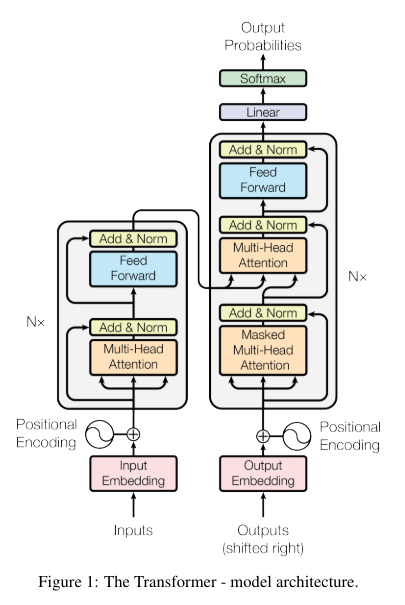

Vaswani et al. (2017)